# Gaussian inference - from the Jura data

In [1]:
import matplotlib.pyplot  as plt
import numpy              as np
import scipy as sp
import eas

## Working with 1D data: The Jura data set
The Jura data set contains 259 observations of different properties (such as location, rock type, and different concentrations of chemical substances).  It can be loaded using 


In [2]:
# Some functions

def gaussian_rw(d0, Cd, r_in=[], is_chol=False, step = 0.1, method='gdm'):
    if is_chol:
        L = Cd
    else:
        L=np.linalg.cholesky(Cd)

    if len(r_in)==0:
        r = np.random.normal(0,1,d0.shape[0])
    else:
        if step>0:
            if method=='gdm':
                step_ang = step*np.pi/2
                r_new = np.random.normal(0,1,d0.shape[0])
                r = r_in*np.cos(step_ang) + r_new*np.sin(step_ang)
            else:
                n = Cd.shape[0]
                n_pert = int(np.ceil(step*n))
                r = r_in
                # select randomly n_pert of out n integer values
                i_pert = np.random.choice(n, n_pert, replace=False)
                r[i_pert]=np.random.normal(0,1,i_pert.shape)
        else:
            r = r_in

    d_star = d0 + np.dot(L,r)
    return d_star, r
    

def precal_distance(x,y):
    nx=len(x)
    ny=len(y)
    xx, yy = np.meshgrid(x,y)
    xx=xx.flatten()
    yy=yy.flatten()
    nd=xx.shape[0]
    d = np.sqrt((xx[:, np.newaxis] - xx[np.newaxis, :]) ** 2 + (yy[:, np.newaxis] - yy[np.newaxis, :]) ** 2)
    return d


def cov_gau(d,r,d_var):
    C  = d_var*np.exp(-3*d**2/r**2)
    C = np.where(d == 0, d_var, C)
    return C

def cov_exp(d,r,d_var):
    C = d_var*np.exp(-3*d/r)
    C = np.where(d == 0, d_var, C)
    return C

def cov_nug(d,d_var):
    C = d_var*(np.where(d == 0, 1.0, 0.0))
    return C
     
def cov_sph(d,r,d_var):
    C = 1-1.5*d/r + 0.5*(d/r)**3
    C = np.where(d > r, 0.0, C)
    C = np.where(d == 0, 1, C)
    C = d_var*C
    return C

def cov_cal(d,r,d_var, model='gaussian'):
    if model=='gaussian':
        return cov_gau(d,r,d_var)
    elif model=='exponential':
        return cov_exp(d,r,d_var)
    elif model=='spherical':
        return cov_sph(d,r,d_var)
    elif model=='nugget':
        return cov_nug(d,d_var)
    else:
        print('Model not found')
        return None

In [3]:
# Read data
DATA     = eas.read(filename='prediction.dat')
d       = DATA['D']
h       = DATA['header']

# Amount of parameters
N       = d.shape[1]

x = d[:,0]
y = d[:,1]
id = 6 # Cr
id = 5 # Co
d = d[:,id]
useLog = 1
nd = d.shape[0]

d_0 = np.mean(d)
d_std = np.std(d)
d_var = np.var(d)

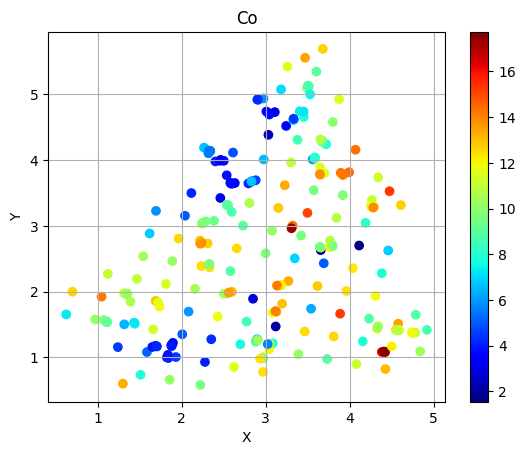

In [4]:
plt.scatter(x,y,c=d,marker='o',cmap='jet')
plt.title(h[id])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.colorbar()

### Setup distance matrix and covariance

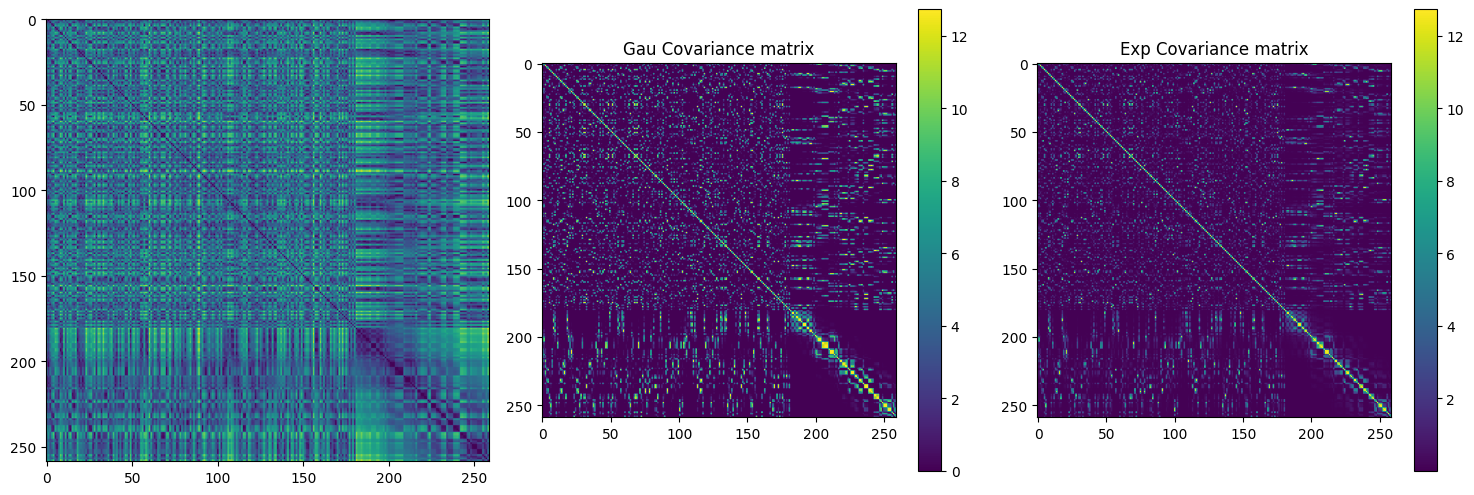

In [5]:
nd=len(d)

dis = np.zeros((nd,nd))
for ix in range(nd):
    for iy in range(nd):
        dis[ix,iy] = np.sqrt((x[ix]-x[iy])**2 + (y[ix]-y[iy])**2)

r=1
C_gau = cov_cal(dis,r,d_var, model='gaussian')
C_exp = cov_cal(dis,r,d_var, model='exponential')
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(dis)
plt.subplot(1,3,2)
plt.imshow(C_gau)
plt.colorbar()
plt.title('Gau Covariance matrix')
plt.subplot(1,3,3)
plt.imshow(C_exp)
plt.colorbar()
plt.title('Exp Covariance matrix')
plt.tight_layout()

### Likelihood based inference of a parametric multivariarte Gaussian pdf

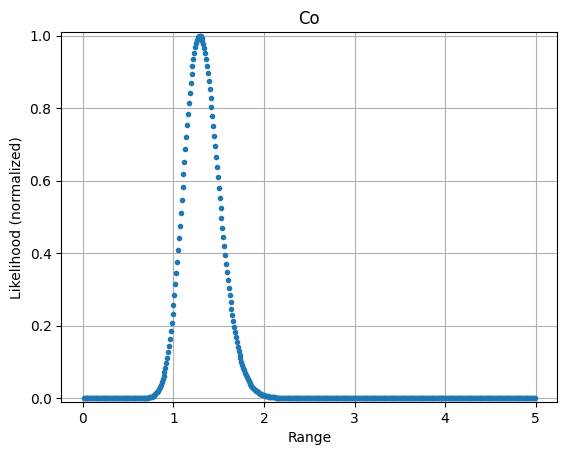

In [6]:

# rage from 0 to 1 with 51 points
range_arr = np.arange(0.01, 5,.01)

nr = range_arr.shape[0]

# Set the noise on data
d_unc_std = 0.1 * d
Cd_unc = np.diag(d_unc_std**2)

# The difference between the data and the mean
dd = d - d_0
L = np.zeros(nr)
for ir in range(nr):
    r = range_arr[ir]
    
    # A: Compute the covariance matrix, 
    C_nug = cov_cal(dis,r,d_var, model='nugget')
    C_exp = cov_cal(dis,r,d_var, model='exponential')
    C_gau = cov_cal(dis,r,d_var, model='gaussian')
    nugget_frac=0.0001
    C = Cd_unc + nugget_frac*C_nug + (1-nugget_frac)*C_exp
    
    # B: Compute the likelihood, L(r)=p(d_obs|C)
    # FOr numerical stabuility, it is best to use log(L) as opposed to L.
 
    f1 = -(nd/2)*np.log(2*np.pi)
    f2 = -0.5 * np.linalg.slogdet(C)[1]
    f3 = -0.5 * np.dot(dd, np.dot(np.linalg.inv(C), dd.T))
    logL = f1 + f2 + f3
    logL = f1+f2+f3

    L[ir] = logL
# C plot the likelihood as a function of r
plt.plot(range_arr, np.exp(L-max(L)),'.')
plt.title(h[id])
plt.xlabel('Range')
plt.ylabel('Likelihood (normalized)')
plt.grid()
plt.ylim(-.01,1.01)

# find index f maximum likelihood
i_max = np.argmax(L)
r_max = range_arr[i_max]

 

In [7]:
x_arr = np.arange(np.min(x),np.max(x),0.1)
y_arr = np.arange(np.min(y),np.max(y),0.1)
nx=len(x_arr)
ny=len(y_arr)
dis_2d = precal_distance(x_arr,y_arr)

C_nug = cov_cal(dis_2d,r_max,d_var, model='nugget')
C_exp = cov_cal(dis_2d,r_max,d_var, model='exponential')
C_gau = cov_cal(dis_2d,r_max,d_var, model='gaussian')
C_max = nugget_frac*C_nug + (1-nugget_frac)*C_exp

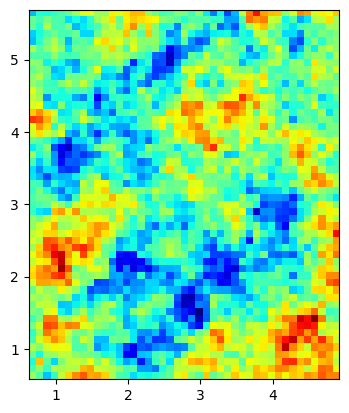

In [8]:
d0 = np.ones(nx*ny)*d_0
d_real = gaussian_rw(d0, C_max)[0]
plt.imshow(d_real.reshape((ny,nx)), cmap='jet', extent=[np.min(x),np.max(x),np.min(y),np.max(y)]) 

## Generata a relization from a Gaussian pdf conditional to the observed data

In [9]:
# to do this we first need to known about linear least squares inversion (or kriging).